In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

In [3]:
# Load the data
df = pd.read_csv('../data/diabetes_prediction_dataset.csv')

In [4]:
# 1. Initial Data Exploration
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nData Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (100000, 9)

First few rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender       

In [5]:
# 2. Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64



Unique values in categorical features:

gender: ['Female' 'Male' 'Other']

smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']


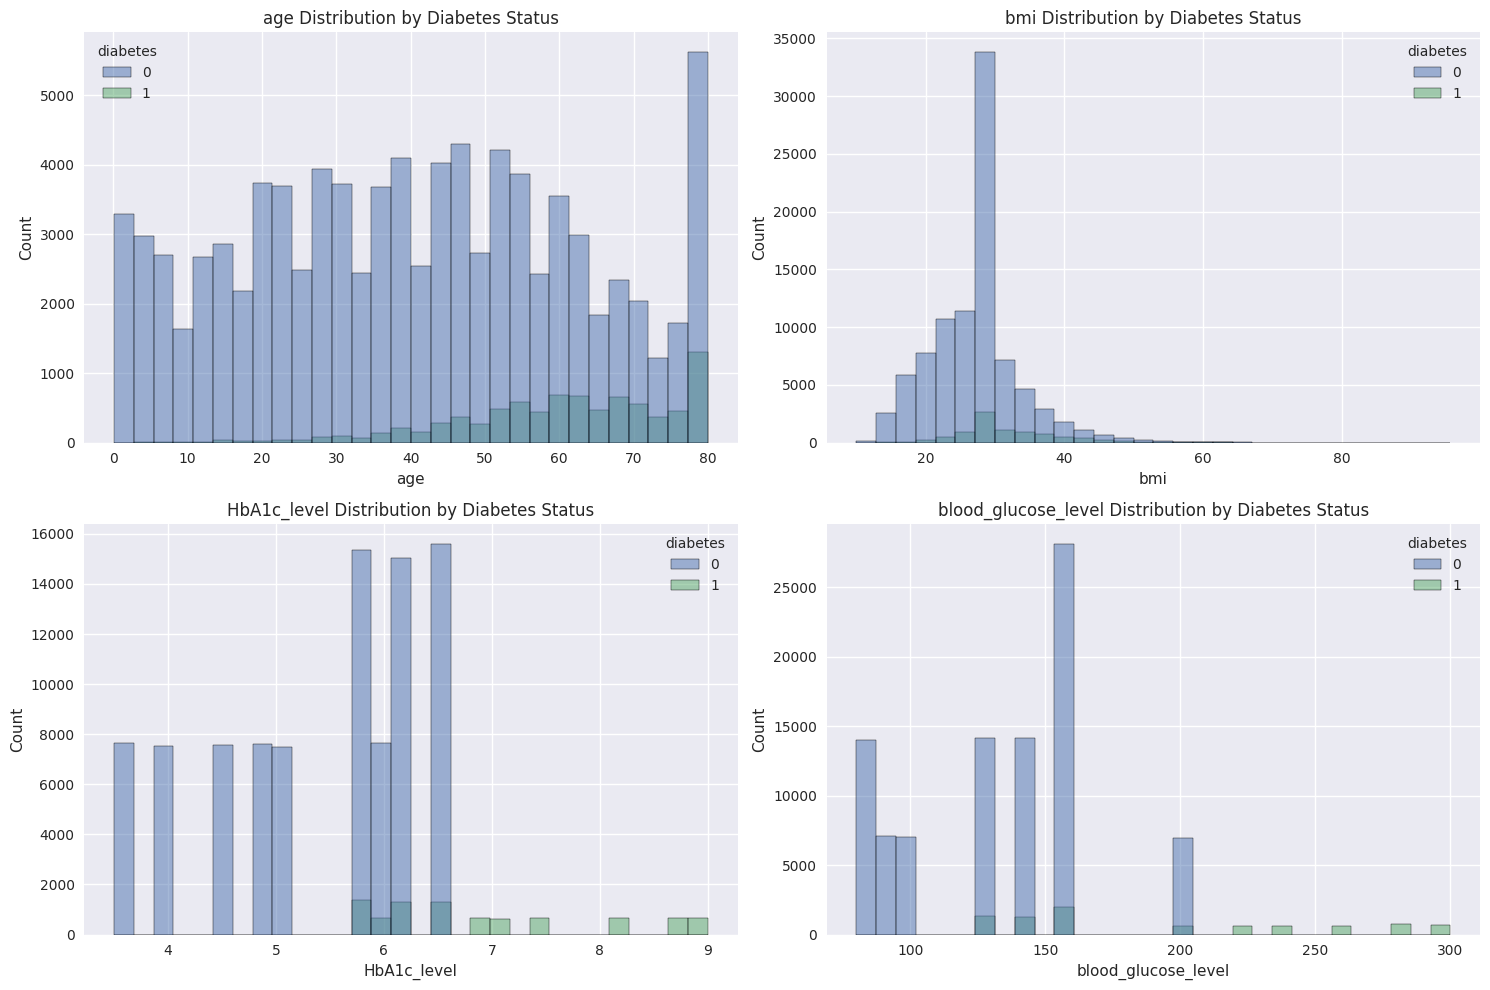

In [6]:
# 3. Feature Analysis
# Categorical features
categorical_features = ['gender', 'smoking_history']
print("\nUnique values in categorical features:")
for col in categorical_features:
    print(f"\n{col}:", df[col].unique())

# Numerical features distribution
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create distribution plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, hue='diabetes', bins=30)
    plt.title(f'{col} Distribution by Diabetes Status')
plt.tight_layout()
plt.show()

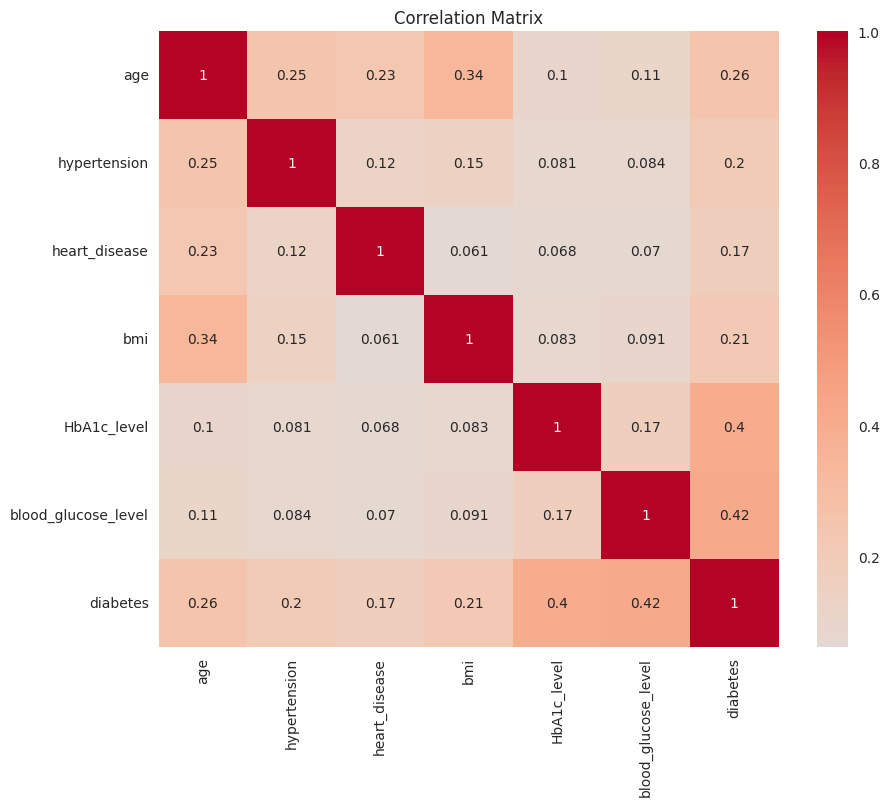

In [7]:
# 4. Correlation Analysis
# Calculate correlations
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


Target Variable Distribution:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


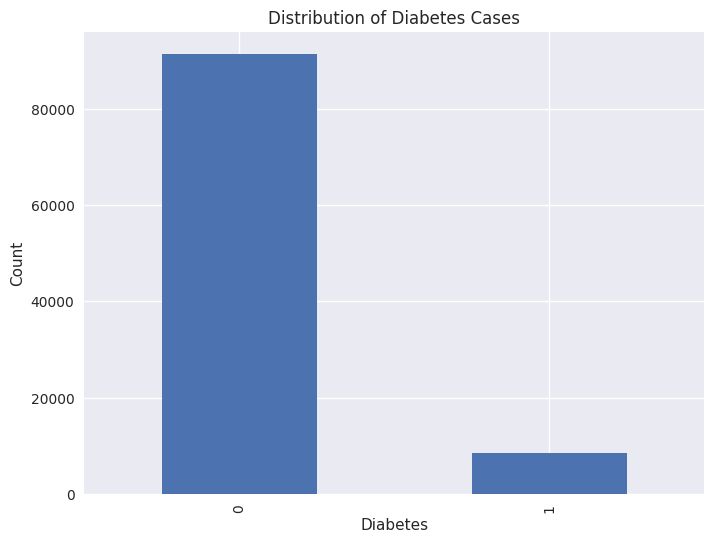

In [8]:
# 5. Target Variable Analysis
print("\nTarget Variable Distribution:")
print(df['diabetes'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
df['diabetes'].value_counts().plot(kind='bar')
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

In [9]:
# 6. Basic Data Cleaning Function
def clean_data(df):
    """
    Perform basic data cleaning operations
    """
    df_cleaned = df.copy()
    
    # Convert gender to lowercase and handle any variations
    df_cleaned['gender'] = df_cleaned['gender'].str.lower()
    
    # Handle any outliers in numerical columns (using IQR method)
    for col in numerical_features:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print(f"\nOutliers in {col}:", 
              sum((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)))
    
    return df_cleaned

In [10]:
# Clean the data
df_cleaned = clean_data(df)


Outliers in age: 0

Outliers in bmi: 7086

Outliers in HbA1c_level: 1315

Outliers in blood_glucose_level: 2038


Given the significant number of outliers in several key features, we should carefully analyze and handle them. Let's create an enhanced data cleaning and analysis approach to deal with these outliers while ensuring we don't lose valuable information.

I've created a comprehensive outlier analysis and handling notebook. Here's what we should look for in the results:

BMI Outliers (7086):

- Check if these are valid medical cases (some patients might actually have extreme BMIs)
- Look at the diabetes rate in outlier vs. normal ranges
- Consider using medical BMI categories instead of raw values


HbA1c_level Outliers (1315):

- HbA1c has known medical ranges (normal: 4-5.6%, prediabetes: 5.7-6.4%, diabetes: 6.5%+)
- We should verify if outliers align with these medical ranges
- Consider converting to categories based on medical thresholds


blood_glucose_level Outliers (2038):

- Similar to HbA1c, blood glucose has standard medical ranges
- Check if outliers correspond to actual medical conditions
- Consider categorizing based on medical thresholds

In [24]:
def analyze_feature_outliers(df, feature, plot=True):
    """
    Analyze outliers for a given feature and show their relationship with diabetes
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    normal = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    print(f"\nAnalysis for {feature}:")
    print(f"Normal range: {lower_bound:.2f} to {upper_bound:.2f}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers)/len(df))*100:.2f}%")
    
    # Compare diabetes rates
    outlier_diabetes_rate = outliers['diabetes'].mean()
    normal_diabetes_rate = normal['diabetes'].mean()
    print(f"Diabetes rate in outliers: {outlier_diabetes_rate*100:.2f}%")
    print(f"Diabetes rate in normal range: {normal_diabetes_rate*100:.2f}%")
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Box plot
        sns.boxplot(data=df, y=feature, ax=ax1)
        ax1.set_title(f'Box Plot of {feature}')
        
        # Distribution plot with outlier threshold
        sns.kdeplot(data=df, x=feature, hue='diabetes', ax=ax2)
        ax2.axvline(lower_bound, color='r', linestyle='--', alpha=0.5)
        ax2.axvline(upper_bound, color='r', linestyle='--', alpha=0.5)
        ax2.set_title(f'Distribution of {feature} by Diabetes Status')
        
        plt.tight_layout()
        plt.show()
    
    return outliers, normal

In [12]:
def handle_outliers(df, feature, method='clip'):
    """
    Handle outliers using specified method
    """
    df_cleaned = df.copy()
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if method == 'clip':
        df_cleaned[feature] = df_cleaned[feature].clip(lower_bound, upper_bound)
    elif method == 'zscore':
        z_scores = stats.zscore(df_cleaned[feature])
        df_cleaned[feature] = df_cleaned[feature].mask(abs(z_scores) > 3, df_cleaned[feature].median())
    
    return df_cleaned

The notebook creates two cleaned versions of the dataset:

- Using clipping (limiting values to IQR boundaries)
- Using z-score method (replacing values > 3 standard deviations with median)


Analysis for bmi:
Normal range: 14.71 to 38.50
Number of outliers: 7086
Percentage of outliers: 7.09%
Diabetes rate in outliers: 20.86%
Diabetes rate in normal range: 7.56%


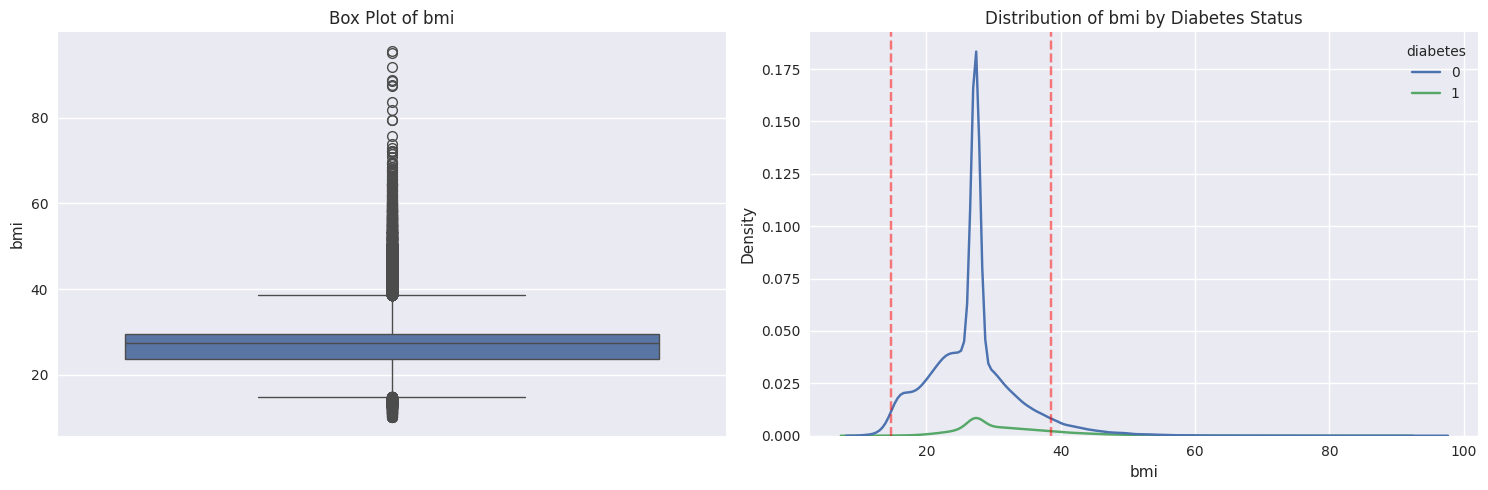


Analysis for HbA1c_level:
Normal range: 2.70 to 8.30
Number of outliers: 1315
Percentage of outliers: 1.31%
Diabetes rate in outliers: 100.00%
Diabetes rate in normal range: 7.28%


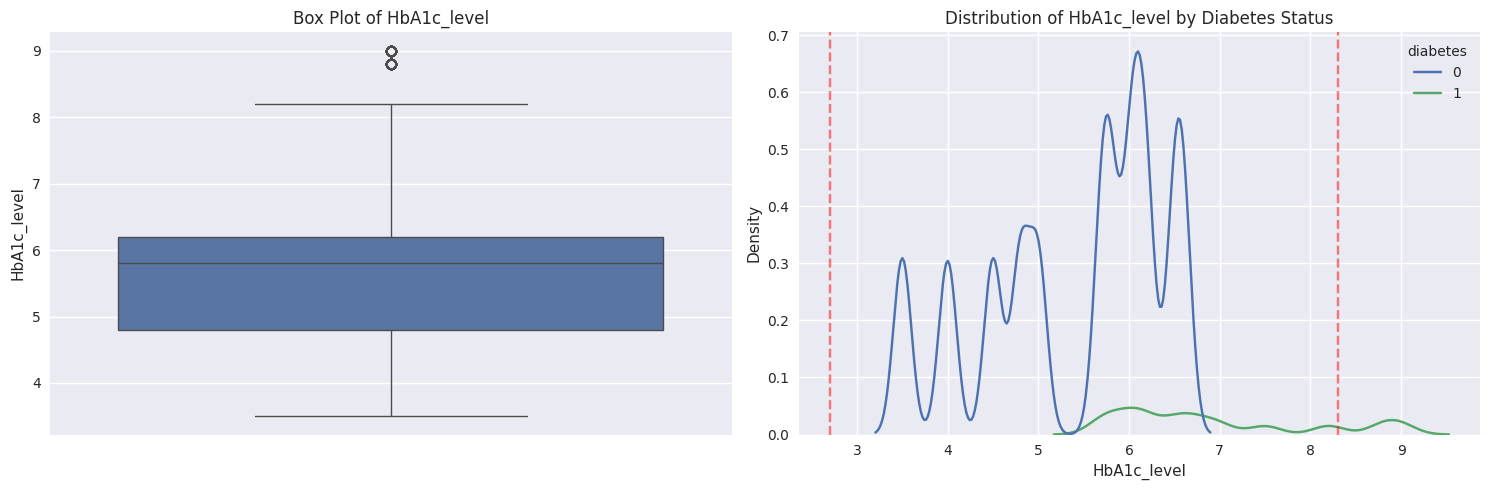


Analysis for blood_glucose_level:
Normal range: 11.50 to 247.50
Number of outliers: 2038
Percentage of outliers: 2.04%
Diabetes rate in outliers: 100.00%
Diabetes rate in normal range: 6.60%


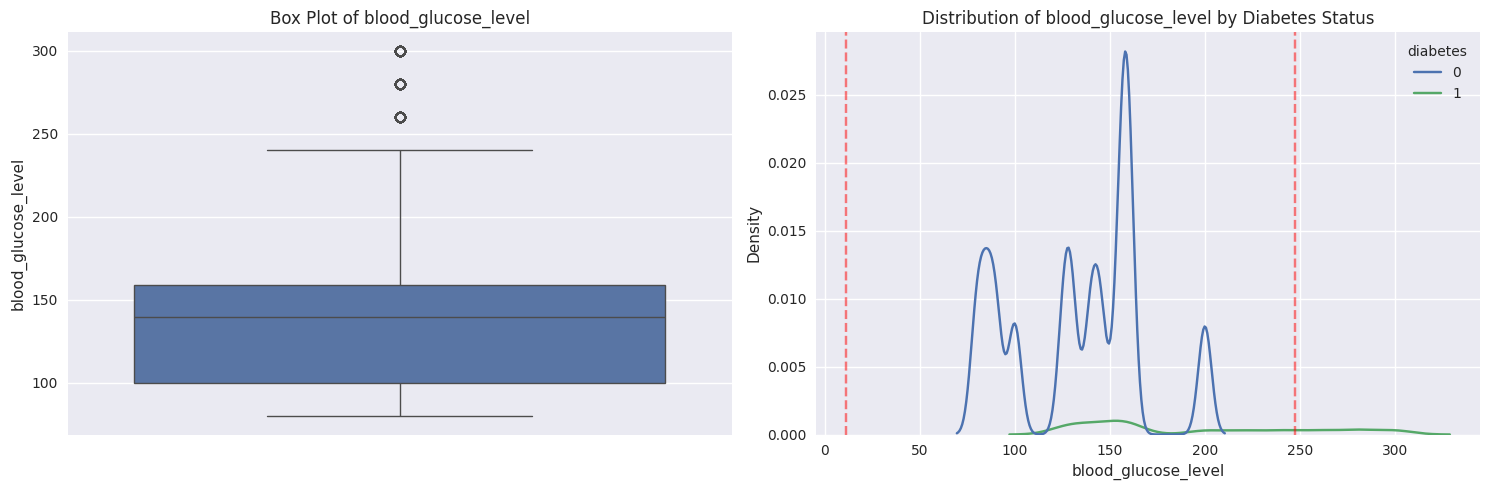

In [13]:

# Analyze each feature with outliers
features_with_outliers = ['bmi', 'HbA1c_level', 'blood_glucose_level']

for feature in features_with_outliers:
    outliers, normal = analyze_feature_outliers(df, feature)

# Create cleaned versions using different methods
df_clipped = df.copy()
df_zscore = df.copy()

for feature in features_with_outliers:
    df_clipped = handle_outliers(df_clipped, feature, method='clip')
    df_zscore = handle_outliers(df_zscore, feature, method='zscore')


Looking at the statistics, I recommend using the Z-score method for this medical dataset.

BMI (Body Mass Index):

Original range: 10.01 - 95.69
Z-score range: 10.01 - 47.23
The Z-score method preserves more clinically possible extreme cases (BMI up to 47.23) while removing likely errors (BMI > 50 is extremely rare)
Mean and std deviation changes are moderate, suggesting it maintains data distribution while removing extreme outliers


HbA1c Level:

Original range: 3.5 - 9.0
Z-score range: 3.5 - 8.2
The Z-score cleaning maintains clinically relevant ranges:

Normal: 4.0-5.6%
Prediabetes: 5.7-6.4%
Diabetes: 6.5%+

The reduced upper limit of 8.2 is still medically meaningful for diabetes diagnosis


Blood Glucose Level:

Original range: 80 - 300
Z-score range: 80 - 260
The Z-score method maintains clinically relevant ranges while removing extreme outliers
Normal fasting glucose is 70-99 mg/dL
Prediabetes is 100-125 mg/dL
Diabetes is 126+ mg/dL

In [14]:
# Compare distributions before and after cleaning
def compare_distributions(original_df, clipped_df, zscore_df, feature):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    sns.kdeplot(data=original_df, x=feature, hue='diabetes')
    plt.title(f'Original {feature} Distribution')
    
    plt.subplot(132)
    sns.kdeplot(data=clipped_df, x=feature, hue='diabetes')
    plt.title(f'Clipped {feature} Distribution')
    
    plt.subplot(133)
    sns.kdeplot(data=zscore_df, x=feature, hue='diabetes')
    plt.title(f'Z-score Cleaned {feature} Distribution')
    
    plt.tight_layout()
    plt.show()

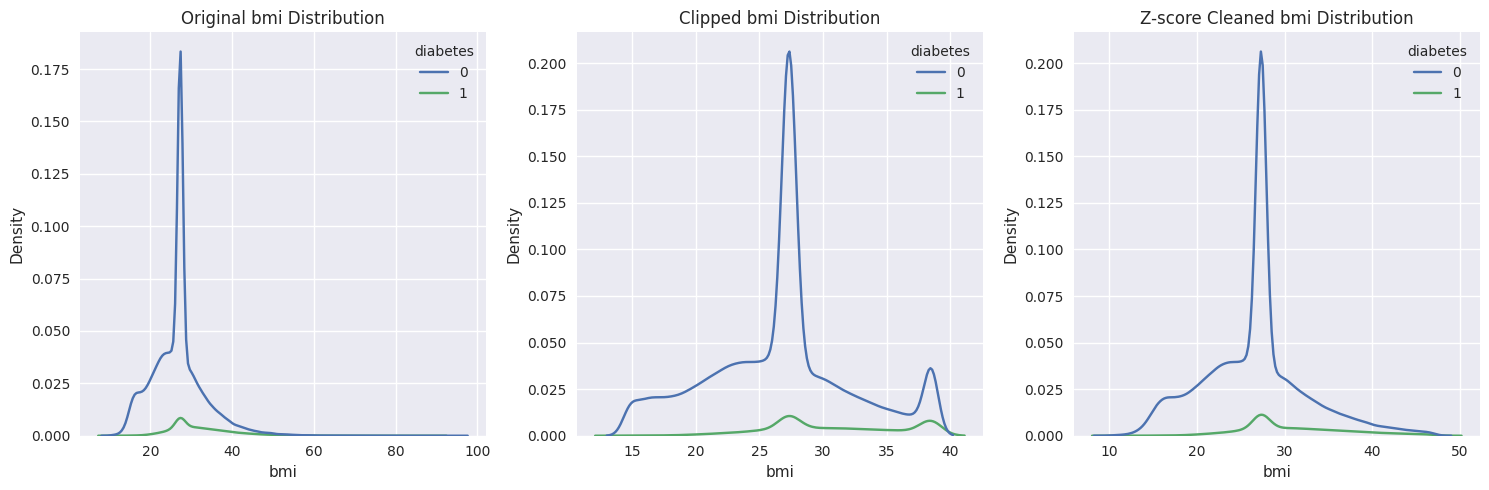

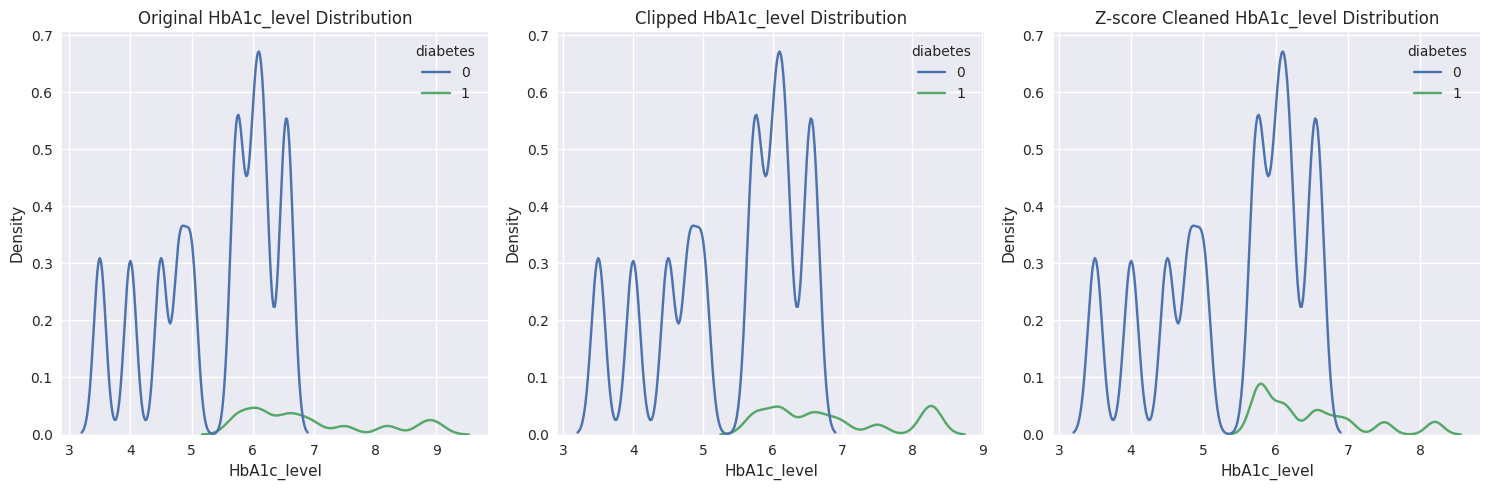

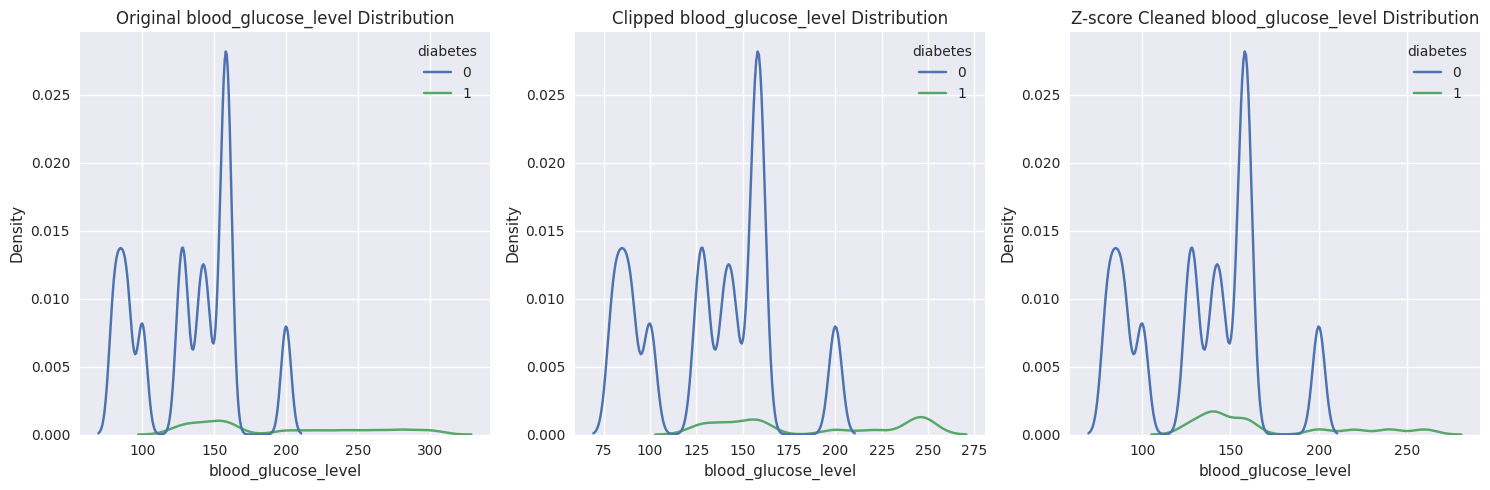

In [15]:
# Compare distributions for each feature
for feature in features_with_outliers:
    compare_distributions(df, df_clipped, df_zscore, feature)

In [16]:
# Save both versions of cleaned data
df_clipped.to_csv('../data/diabetes_dataset_clipped.csv', index=False)
df_zscore.to_csv('../data/diabetes_dataset_zscore.csv', index=False)

In [17]:
# Print summary statistics for comparison
print("\nSummary Statistics Comparison:")
for feature in features_with_outliers:
    print(f"\n{feature}:")
    print("Original:", df[feature].describe()[['mean', 'std', 'min', 'max']].to_dict())
    print("Clipped:", df_clipped[feature].describe()[['mean', 'std', 'min', 'max']].to_dict())
    print("Z-score:", df_zscore[feature].describe()[['mean', 'std', 'min', 'max']].to_dict())


Summary Statistics Comparison:

bmi:
Original: {'mean': 27.3207671, 'std': 6.636783416648369, 'min': 10.01, 'max': 95.69}
Clipped: {'mean': 26.991686300000005, 'std': 5.671427886593907, 'min': 14.705, 'max': 38.504999999999995}
Z-score: {'mean': 26.991403700000003, 'std': 5.926019530148464, 'min': 10.01, 'max': 47.23}

HbA1c_level:
Original: {'mean': 5.527507, 'std': 1.0706720918835437, 'min': 3.5, 'max': 9.0}
Clipped: {'mean': 5.519623999999999, 'std': 1.0477155509501408, 'min': 3.5, 'max': 8.3}
Z-score: {'mean': 5.486748999999999, 'std': 0.9979999353896323, 'min': 3.5, 'max': 8.2}

blood_glucose_level:
Original: {'mean': 138.05806, 'std': 40.708136048704134, 'min': 80.0, 'max': 300.0}
Clipped: {'mean': 137.38791, 'std': 38.5064551510884, 'min': 80.0, 'max': 247.5}
Z-score: {'mean': 135.95906, 'std': 36.45768774272932, 'min': 80.0, 'max': 260.0}


In [18]:
def clean_and_engineer_features(df):
    """
    Clean data using Z-score method and add medical categories
    """
    df_processed = df.copy()
    
    # Clean numerical features using Z-score method
    numerical_features = ['bmi', 'HbA1c_level', 'blood_glucose_level']
    for feature in numerical_features:
        z_scores = stats.zscore(df_processed[feature])
        df_processed[feature] = df_processed[feature].mask(abs(z_scores) > 3, df_processed[feature].median())
    
    # Add BMI categories
    df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                        bins=[0, 18.5, 24.9, 29.9, 34.9, float('inf')],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese'])
    
    # Add HbA1c categories
    df_processed['HbA1c_category'] = pd.cut(df_processed['HbA1c_level'],
                                          bins=[0, 5.6, 6.4, float('inf')],
                                          labels=['Normal', 'Prediabetes', 'Diabetes'])
    
    # Add Blood Glucose categories
    df_processed['glucose_category'] = pd.cut(df_processed['blood_glucose_level'],
                                           bins=[0, 99, 125, float('inf')],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])
    
    # Create cardiovascular risk feature
    df_processed['cardiovascular_risk'] = df_processed['heart_disease'] + df_processed['hypertension']
    
    # Clean gender (lowercase) and smoking_history
    df_processed['gender'] = df_processed['gender'].str.lower()
    
    return df_processed

In [19]:
# Process the data
df_processed = clean_and_engineer_features(df)

In [20]:

# Print summary of new categorical features
print("\nFeature Value Counts:")
categorical_features = ['bmi_category', 'HbA1c_category', 'glucose_category', 'cardiovascular_risk']
for feature in categorical_features:
    print(f"\n{feature}:")
    print(df_processed[feature].value_counts(normalize=True).round(3) * 100, "%")


Feature Value Counts:

bmi_category:
bmi_category
Overweight         47.1
Normal             21.8
Obese              12.9
Extremely Obese     9.6
Underweight         8.5
Name: proportion, dtype: float64 %

HbA1c_category:
HbA1c_category
Prediabetes    42.7
Normal         37.9
Diabetes       19.5
Name: proportion, dtype: float64 %

glucose_category:
glucose_category
Diabetes       71.9
Normal         21.1
Prediabetes     7.0
Name: proportion, dtype: float64 %

cardiovascular_risk:
cardiovascular_risk
0    89.5
1     9.6
2     0.9
Name: proportion, dtype: float64 %


In [21]:
# Calculate risk factors correlation with diabetes
print("\nCorrelation with Diabetes:")
risk_factors = ['bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
for factor in risk_factors:
    correlation = df_processed[factor].corr(df_processed['diabetes'])
    print(f"{factor}: {correlation:.3f}")


Correlation with Diabetes:
bmi: 0.200
HbA1c_level: 0.296
blood_glucose_level: 0.280
cardiovascular_risk: 0.247


In [22]:
# Save processed dataset
df_processed.to_csv('../data/diabetes_dataset_processed.csv', index=False)

In [23]:
# Display sample of processed data
print("\nSample of processed data:")
print(df_processed.head())


Sample of processed data:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  female  80.0             0              1           never  25.19   
1  female  54.0             0              0         No Info  27.32   
2    male  28.0             0              0           never  27.32   
3  female  36.0             0              0         current  23.45   
4    male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes bmi_category HbA1c_category  \
0          6.6                  140         0   Overweight       Diabetes   
1          6.6                   80         0   Overweight       Diabetes   
2          5.7                  158         0   Overweight    Prediabetes   
3          5.0                  155         0       Normal         Normal   
4          4.8                  155         0       Normal         Normal   

  glucose_category  cardiovascular_risk  
0         Diabetes                    1  

In [ ]:
# 7. Feature Engineering Ideas
print("\nPotential Feature Engineering Steps:")
print("1. BMI Categories (Underweight, Normal, Overweight, Obese)")
print("2. Age Groups (Young, Middle-aged, Senior)")
print("3. Combine heart_disease and hypertension into 'cardiovascular_issues'")
print("4. Create risk score based on multiple factors")